## 1. Importing Libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install unidecode

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 1.9 MB/s eta 0:00:00


In [3]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [4]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [5]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [6]:
!pip install autocorrect

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 622.8/622.8 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for autocorrect: filename=autocorrect-2.6.1-py3-none-any.whl size=622364 sha256=a2fb7f335d4b4c657a69ade75f3a1a633ee17341afb67a3153bbbfc6b31b11d8
  Stored in directory: /root/.cache/pip/wheels/b5/7b/6d/b76b29ce11ff8e2521c8c7dd0e5bfee4fb1789d76193124343
Successfully built autocorrect


In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots

import warnings
warnings.filterwarnings("ignore")

import nltk

# It helps to remove the accented characters
import unidecode

from nltk.tokenize import word_tokenize,sent_tokenize,regexp_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
import re,string,unicodedata
from wordcloud import WordCloud,STOPWORDS
from bs4 import BeautifulSoup

# It help to correct the spellings
from autocorrect import Speller

from sklearn.metrics import classification_report,confusion_matrix, ConfusionMatrixDisplay, accuracy_score,f1_score,precision_score,recall_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBClassifier

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Dense,Input, Embedding,LSTM,Dropout,Conv1D, MaxPooling1D, GlobalMaxPooling1D,Dropout,Bidirectional,Flatten,BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
import transformers
import tokenizers
import json

# 2. Data Extraction and Cleaning

In [8]:
data=pd.read_csv('/content/drive/MyDrive/thought classification/data_thought.csv')

In [9]:
data.head()

,Thought,Label
0,Everyone is probably mad at me,negative
1,You're braver than you believe,positive
2,"When I open my eyes, you're all that I want to...",positive
3,They clearly don’t want to be friends with me ...,negative
4,I've never done it before.,negative


In [10]:
## Assess the shape of the data
print("The Shape of the Dataset",data.shape)

The Shape of the Dataset (156785, 2)


In [11]:
data.describe()

,Thought,Label
count,156785,156785
unique,129051,2
top,Help,positive
freq,65,85677


In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156785 entries, 0 to 156784
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   Thought  156785 non-null  object
 1   Label    156785 non-null  object
dtypes: object(2)
memory usage: 2.4+ MB


In [13]:
data['Label'].unique()

array(['negative', 'positive'], dtype=object)

In [14]:
print(data['Label'].value_counts())

Label
positive    85677
negative    71108
Name: count, dtype: int64


In [15]:
null_values = data.isnull().sum()  #check null values
print(null_values)

Thought    0
Label      0
dtype: int64


In [16]:
data = data.dropna(how='any',axis=0) #drop null values

In [17]:
num_duplicates = data.duplicated().sum() #identify duplicates
print('There are {} duplicate thought present in the dataset'.format(num_duplicates))

There are 27705 duplicate thought present in the dataset


In [18]:
#view duplicate thoughts
thought = data['Thought']
duplicated_thought = data[thought.isin(thought[thought.duplicated()])].sort_values("Thought")


In [19]:
#drop duplicate thoughts
data.drop_duplicates(inplace = True)

In [20]:
#reseting the index of data frame since some rows have been deleted
data.reset_index(drop=True, inplace=True)

In [21]:
print('The dataset contains {} rows and {} columns after removing duplicates'.format(data.shape[0],data.shape[1]))

The dataset contains 129080 rows and 2 columns after removing duplicates


In [22]:
# Define a custom set of stopwords excluding pronouns and sentiment-carrying words
custom_stopwords = set([
    'a', 'about', 'above', 'after', 'again', 'against', 'am', 'an', 'and', 'any', 'are', 'aren\'t', 'as', 'at',
    'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'cannot', 'can\'t',
    'could', 'couldn\'t', 'did', 'didn\'t', 'do', 'does', 'doesn\'t', 'doing', 'don\'t', 'down', 'during', 'each',
    'few', 'for', 'from', 'further', 'had', 'hadn\'t', 'has', 'hasn\'t', 'have', 'haven\'t', 'having', 'he',
    'he\'d', 'he\'ll', 'he\'s', 'her', 'here', 'here\'s', 'hers', 'herself', 'him', 'himself', 'his', 'how',
    'how\'s', 'if', 'in', 'into', 'is', 'isn\'t', 'it', 'it\'s', 'its', 'itself', 'let\'s', 'me', 'more', 'most',
    'mustn\'t', 'my', 'myself', 'no', 'nor', 'not', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'ought',
    'our', 'ours', 'ourselves', 'out', 'over', 'own', 'same', 'shan\'t', 'she', 'she\'d', 'she\'ll', 'she\'s',
    'should', 'shouldn\'t', 'so', 'some', 'such', 'than', 'that', 'that\'s', 'the', 'their', 'theirs', 'them',
    'themselves', 'then', 'there', 'there\'s', 'these', 'they', 'they\'d', 'they\'ll', 'they\'re', 'they\'ve',
    'this', 'those', 'through', 'to', 'too', 'under', 'until', 'up', 'very', 'was', 'wasn\'t', 'we', 'we\'d',
    'we\'ll', 'we\'re', 'we\'ve', 'were', 'weren\'t', 'what', 'what\'s', 'when', 'when\'s', 'where', 'where\'s',
    'which', 'while', 'who', 'who\'s', 'whom', 'why', 'why\'s', 'with', 'won\'t', 'would', 'wouldn\'t',
    'you', 'you\'d', 'you\'ll', 'you\'re', 'you\'ve', 'your', 'yours', 'yourself', 'yourselves'
]) - {'i', 'we', 'me', 'you', 'they', 'no', 'not', 'aren\'t', 'cannot', 'can\'t', 'don\'t', 'didn\'t',  'doesn\'t','won\'t', 'couldn\'t',
      'hadn\'t', 'hasn\'t', 'haven\'t', 'isn\'t', 'mustn\'t', 'shan\'t', 'shouldn\'t', 'wasn\'t', 'weren\'t', 'won\'t', 'wouldn\'t'}

In [23]:
# Contraction map
contraction_mapping  = {"ain't": "is not", "aren't": "are not","can't": "can not",
           "'cause": "because", "could've": "could have", "couldn't": "could not",
           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not",
           "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will",
           "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will",
           "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will",
           "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have",
           "i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have",
           "it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not",
           "might've": "might have","mightn't": "might not","mightn't've": "might not have",
           "must've": "must have", "mustn't": "must not", "mustn't've": "must not have",
           "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not",
           "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would",
           "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have",
           "she's": "she is", "should've": "should have", "shouldn't": "should not",
           "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is",
           "that'd": "that would", "that'd've": "that would have", "that's": "that is",
           "there'd": "there would", "there'd've": "there would have", "there's": "there is",
           "here's": "here is","they'd": "they would", "they'd've": "they would have",
           "they'll": "they will", "they'll've": "they will have", "they're": "they are",
           "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would",
           "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have",
           "we're": "we are", "we've": "we have", "weren't": "were not",
           "what'll": "what will", "what'll've": "what will have","what're": "what are",
           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have",
           "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will",
           "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is",
           "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have",
           "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have",
           "y'all're": "you all are","y'all've": "you all have","you'd": "you would",
           "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
           "you're": "you are", "you've": "you have" }

## Text Preprocessing

### Remove accented characters

In [24]:
# defining an empty list
text = []

# looping over each message in the data
for i in range(data.shape[0]):

    t = data['Thought'][i].split()
    # Applying the unicode data on a sentence and replacing the accented words to get the closest possible ASCII text
    new_text = [unidecode.unidecode(word) for word in t]

    # Combining the seperate words into sentence
    new_text = ' '.join(new_text)
    # append the new_text to list text
    text.append(new_text)

data['cleaned_text'] = text

In [25]:
data.head()

,Thought,Label,cleaned_text
0,Everyone is probably mad at me,negative,Everyone is probably mad at me
1,You're braver than you believe,positive,You're braver than you believe
2,"When I open my eyes, you're all that I want to...",positive,"When I open my eyes, you're all that I want to..."
3,They clearly don’t want to be friends with me ...,negative,They clearly don't want to be friends with me ...
4,I've never done it before.,negative,I've never done it before.


### Lowercasing

In [26]:

# defining an empty list
text = []

# looping over each message in the data
for i in range(data.shape[0]):
    # lowecasing the text using the lower() function
    new_text = data['cleaned_text'][i].lower()
    text.append(new_text) # append the new_text to empty list text

data['cleaned_text'] = text


In [27]:
data.head()

,Thought,Label,cleaned_text
0,Everyone is probably mad at me,negative,everyone is probably mad at me
1,You're braver than you believe,positive,you're braver than you believe
2,"When I open my eyes, you're all that I want to...",positive,"when i open my eyes, you're all that i want to..."
3,They clearly don’t want to be friends with me ...,negative,they clearly don't want to be friends with me ...
4,I've never done it before.,negative,i've never done it before.


In [28]:
#emoji clean
def clean_emoji(text):
    emoji_clean= re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_clean.sub(r'',text)

# Removing URL's
def remove_URL(text):
    return re.sub(r'http\S+', '', text)
# remove all single characters

# Substituting multiple spaces with single space
def Sub_multiple_space(text):
    return re.sub(r'\s+', ' ', text, flags=re.I)

#Removing the noisy text
def exclude_noisy_text(text):
  text = clean_emoji(text)
  text = remove_URL(text)
  text = Sub_multiple_space(text)

  return text



In [29]:
data['cleaned_text']=data['cleaned_text'].apply(exclude_noisy_text)

### Expand contractions

In [30]:
# Function to expand contractions using the predefined map
def expand_contractions(text):
    for contraction, expanded in contraction_mapping.items():
        text = re.sub(r'\b' + contraction + r'\b', expanded, text)
    return text

In [31]:
# defining an empty list
text = []

# looping over each message in the data
for i in range(data.shape[0]):
    # applying the autospell function on the text messages
    new_text = expand_contractions(data['cleaned_text'][i])
    text.append(new_text) # append the new_text to empty list text

data['cleaned_text'] = text

In [32]:
data.head()

,Thought,Label,cleaned_text
0,Everyone is probably mad at me,negative,everyone is probably mad at me
1,You're braver than you believe,positive,you are braver than you believe
2,"When I open my eyes, you're all that I want to...",positive,"when i open my eyes, you are all that i want t..."
3,They clearly don’t want to be friends with me ...,negative,they clearly do not want to be friends with me...
4,I've never done it before.,negative,i have never done it before.


In [33]:
data.tail()

,Thought,Label,cleaned_text
129075,Their appreciation for complexity allows them ...,positive,their appreciation for complexity allows them ...
129076,I can't wait to go on vacation next month.,negative,i can not wait to go on vacation next month.
129077,Itâ€™s OK to SCREW Up! Nigel Raw,positive,itaeur(tm)s ok to screw up! nigel raw
129078,Itâ€™s here. Itâ€™s beautiful. Itâ€™s signed. ...,positive,itaeur(tm)s here. itaeur(tm)s beautiful. itaeu...
129079,Stuck On You â€“ Cover by Alicia Widar,negative,"stuck on you aeur"" cover by alicia widar"


### Removing punctuation

In [34]:
#removing punctuation
text = []

# looping over each message in the data
for i in range(data.shape[0]):
    words = data['cleaned_text'][i].split() # splitting text into separate words
    # Create a translation table that maps each punctuation character to None
    translator = str.maketrans('', '', ',.!:')
    # Use the translate method to remove punctuation
    new_text = ' '.join([word.translate(translator) for word in words])
    text.append(new_text)
data['cleaned_text'] = text

In [35]:
data.head()

,Thought,Label,cleaned_text
0,Everyone is probably mad at me,negative,everyone is probably mad at me
1,You're braver than you believe,positive,you are braver than you believe
2,"When I open my eyes, you're all that I want to...",positive,when i open my eyes you are all that i want to...
3,They clearly don’t want to be friends with me ...,negative,they clearly do not want to be friends with me...
4,I've never done it before.,negative,i have never done it before


In [36]:
data.tail()

,Thought,Label,cleaned_text
129075,Their appreciation for complexity allows them ...,positive,their appreciation for complexity allows them ...
129076,I can't wait to go on vacation next month.,negative,i can not wait to go on vacation next month
129077,Itâ€™s OK to SCREW Up! Nigel Raw,positive,itaeur(tm)s ok to screw up nigel raw
129078,Itâ€™s here. Itâ€™s beautiful. Itâ€™s signed. ...,positive,itaeur(tm)s here itaeur(tm)s beautiful itaeur(...
129079,Stuck On You â€“ Cover by Alicia Widar,negative,"stuck on you aeur"" cover by alicia widar"


### Removing Special Characters

In [37]:

# defining an empty list
text = []

# looping over each message in the data
for i in range(data.shape[0]):
    words = data['cleaned_text'][i].split() # splitting text into separate words
    new_text = ' '.join([element for element in words if element.isalnum()]) # looping over each element of the list and using the join() function to retrive the original text
    text.append(new_text)  # append the new_text to empty list text

data['cleaned_text'] = text



In [38]:
data.head()

,Thought,Label,cleaned_text
0,Everyone is probably mad at me,negative,everyone is probably mad at me
1,You're braver than you believe,positive,you are braver than you believe
2,"When I open my eyes, you're all that I want to...",positive,when i open my eyes you are all that i want to...
3,They clearly don’t want to be friends with me ...,negative,they clearly do not want to be friends with me...
4,I've never done it before.,negative,i have never done it before


In [39]:
data.tail()

,Thought,Label,cleaned_text
129075,Their appreciation for complexity allows them ...,positive,their appreciation for complexity allows them ...
129076,I can't wait to go on vacation next month.,negative,i can not wait to go on vacation next month
129077,Itâ€™s OK to SCREW Up! Nigel Raw,positive,ok to screw up nigel raw
129078,Itâ€™s here. Itâ€™s beautiful. Itâ€™s signed. ...,positive,here beautiful signed it fits right in
129079,Stuck On You â€“ Cover by Alicia Widar,negative,stuck on you cover by alicia widar


### Spellchecking

In [40]:
# intializing the spellchecker and setting the language to english
spell = Speller(lang = 'en')

# defining a function which will take text as an input break
def autospell(text):
    '''
    A function which takes text as an input, performs a spell check, and autocorrects misspelled words
    text: text input (object)
    '''
    word = text.split() # splitting text into separate words
    spells = [spell(w) for w in word] # Spell checking on each word
    return " ".join(spells) # retriving the original text


In [41]:

# defining an empty list
text = []

# looping over each message in the data
for i in range(data.shape[0]):
    # applying the autospell function on the text messages
    new_text = autospell(data['cleaned_text'][i])
    text.append(new_text) # append the new_text to empty list text

data['cleaned_text'] = text


In [42]:
data.head()

,Thought,Label,cleaned_text
0,Everyone is probably mad at me,negative,everyone is probably mad at me
1,You're braver than you believe,positive,you are brave than you believe
2,"When I open my eyes, you're all that I want to...",positive,when i open my eyes you are all that i want to...
3,They clearly don’t want to be friends with me ...,negative,they clearly do not want to be friends with me...
4,I've never done it before.,negative,i have never done it before


In [43]:
data.tail()

,Thought,Label,cleaned_text
129075,Their appreciation for complexity allows them ...,positive,their appreciation for complexity allows them ...
129076,I can't wait to go on vacation next month.,negative,i can not wait to go on vacation next month
129077,Itâ€™s OK to SCREW Up! Nigel Raw,positive,ok to screw up nigel raw
129078,Itâ€™s here. Itâ€™s beautiful. Itâ€™s signed. ...,positive,here beautiful signed it fits right in
129079,Stuck On You â€“ Cover by Alicia Widar,negative,stuck on you cover by alicia wider


In [44]:
# Function to consolidate pronouns
def consolidate_pronouns(tokens):
    consolidated_tokens = []
    for token in tokens.split():
        if token in ['i', 'we', 'me']:
            consolidated_tokens.append('me')
        elif token in ['you']:
            consolidated_tokens.append('you')
        elif token in ['they', 'them']:
            consolidated_tokens.append('they')
        else:
            consolidated_tokens.append(token)

    return ' '.join(consolidated_tokens)

In [45]:
wl = WordNetLemmatizer()

In [46]:
#tokenization and removing stop words
def tokenization(text):
    text_tokens = word_tokenize(text)
    filtered_text = [w for w in text_tokens if not w in custom_stopwords]  #Removing stop words
    return " ".join(filtered_text)


#lemmatize
def lemmatization(text, lemmatize= True):
    if lemmatize:
        return " ".join([wl.lemmatize(word) for word in text.split() if word not in custom_stopwords and word.isalpha()])
    else:
        return " ".join([word for word in text.split() if word not in custom_stopwords and word.isalpha()])

#Removing the noisy text
def clean_text(text):

    text = consolidate_pronouns(text)
    text = tokenization(text)
    text = lemmatization(text, lemmatize= True)


    return text

In [47]:
data_copy = data.copy()

In [48]:
#data['Thought_clean']=data['Thought'].apply(clean_text,lemmatize = True)
data['Thought_clean']=data['cleaned_text'].apply(clean_text)

In [49]:
data.head()

,Thought,Label,cleaned_text,Thought_clean
0,Everyone is probably mad at me,negative,everyone is probably mad at me,everyone probably mad me
1,You're braver than you believe,positive,you are brave than you believe,you brave you believe
2,"When I open my eyes, you're all that I want to...",positive,when i open my eyes you are all that i want to...,me open eye you all me want see
3,They clearly don’t want to be friends with me ...,negative,they clearly do not want to be friends with me...,they clearly not want friend me anymore
4,I've never done it before.,negative,i have never done it before,me never done


In [50]:
data.tail()

,Thought,Label,cleaned_text,Thought_clean
129075,Their appreciation for complexity allows them ...,positive,their appreciation for complexity allows them ...,appreciation complexity allows they see interc...
129076,I can't wait to go on vacation next month.,negative,i can not wait to go on vacation next month,me can not wait go vacation next month
129077,Itâ€™s OK to SCREW Up! Nigel Raw,positive,ok to screw up nigel raw,ok screw nigel raw
129078,Itâ€™s here. Itâ€™s beautiful. Itâ€™s signed. ...,positive,here beautiful signed it fits right in,beautiful signed fit right
129079,Stuck On You â€“ Cover by Alicia Widar,negative,stuck on you cover by alicia wider,stuck you cover alicia wider


## 3. Exploratory data analysis

In [51]:
print(data['Label'].value_counts())

Label
positive    71185
negative    57895
Name: count, dtype: int64


In [52]:
print('Positive thoughts are', (round(data['Label'].value_counts()[0])),'i.e.', round(data['Label'].value_counts()[0]/len(data) * 100,2), '% of the dataset')
print('Negative thoughts are', (round(data['Label'].value_counts()[1])),'i.e.',round(data['Label'].value_counts()[1]/len(data) * 100,2), '% of the dataset')

Positive thoughts are 71185 i.e. 55.15 % of the dataset
Negative thoughts are 57895 i.e. 44.85 % of the dataset


Text(0.5, 1.0, 'Thought Distribution')

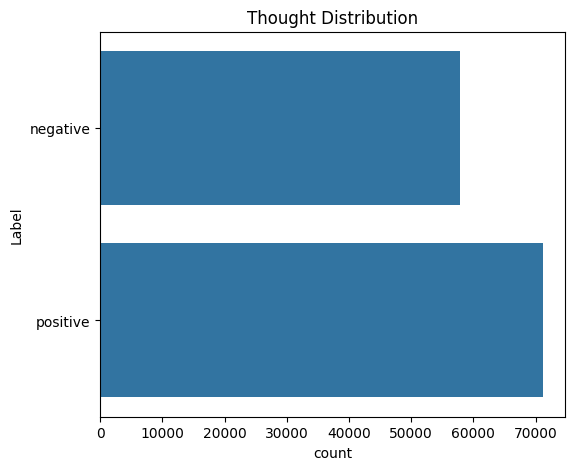

In [53]:
plt.figure(figsize =(6,5))
sns.countplot(data['Label'])
plt.title("Thought Distribution")

In [54]:
#converting target variable to numeric labels
data.Label = [ 1 if each == "positive" else 0 for each in data.Label]

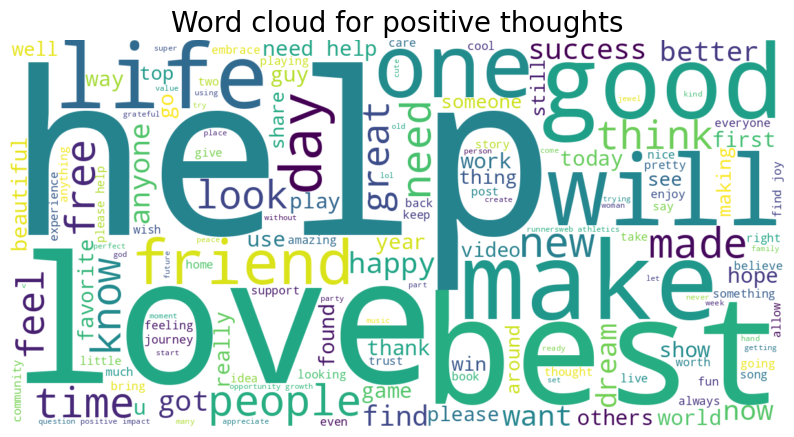

In [55]:
#word cloud for positive thought
positive_data = data[data.Label == 1].Thought_clean
positive_data_string = " ".join(positive_data)
plt.figure(figsize = (10,10))
wc = WordCloud(max_words = 150, width=1200, height=600,background_color="white").generate(positive_data_string)
plt.imshow(wc , interpolation = 'bilinear')
plt.axis('off')
plt.title('Word cloud for positive thoughts',fontsize = 20)
plt.show()

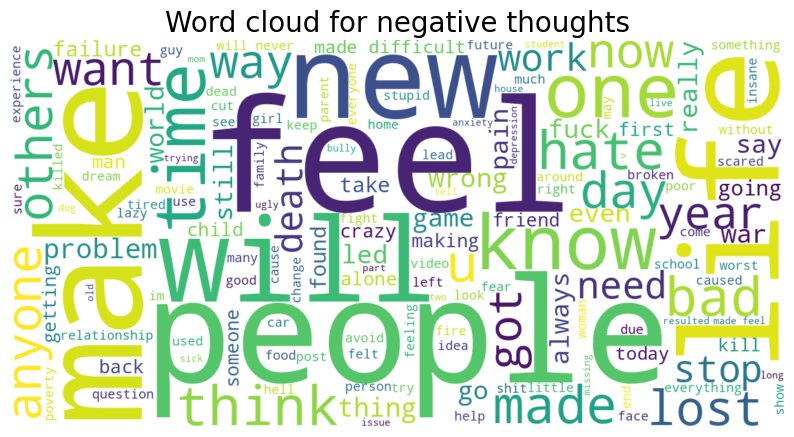

In [56]:
#word cloud for negative thought
negative_data = data[data.Label == 0].Thought_clean
negative_data_string = " ".join(negative_data)
plt.figure(figsize = (10,10))
wc = WordCloud(max_words = 150, width=1200, height=600,background_color="white").generate(negative_data_string)
plt.imshow(wc , interpolation = 'bilinear')
plt.axis('off')
plt.title('Word cloud for negative thoughts',fontsize = 20)
plt.show()

## 4. Feature Extraction

In [57]:
def extracting_len_of_thought (data,col_name):
   w = data[col_name].apply(lambda x :x.lower())
   len_of_thought = [len(word_tokenize(i)) for i in w]
   return len_of_thought

In [58]:
data['n_of_words'] = extracting_len_of_thought(data,'Thought')
data.head()

,Thought,Label,cleaned_text,Thought_clean,n_of_words
0,Everyone is probably mad at me,0,everyone is probably mad at me,everyone probably mad me,6
1,You're braver than you believe,1,you are brave than you believe,you brave you believe,6
2,"When I open my eyes, you're all that I want to...",1,when i open my eyes you are all that i want to...,me open eye you all me want see,14
3,They clearly don’t want to be friends with me ...,0,they clearly do not want to be friends with me...,they clearly not want friend me anymore,12
4,I've never done it before.,0,i have never done it before,me never done,7


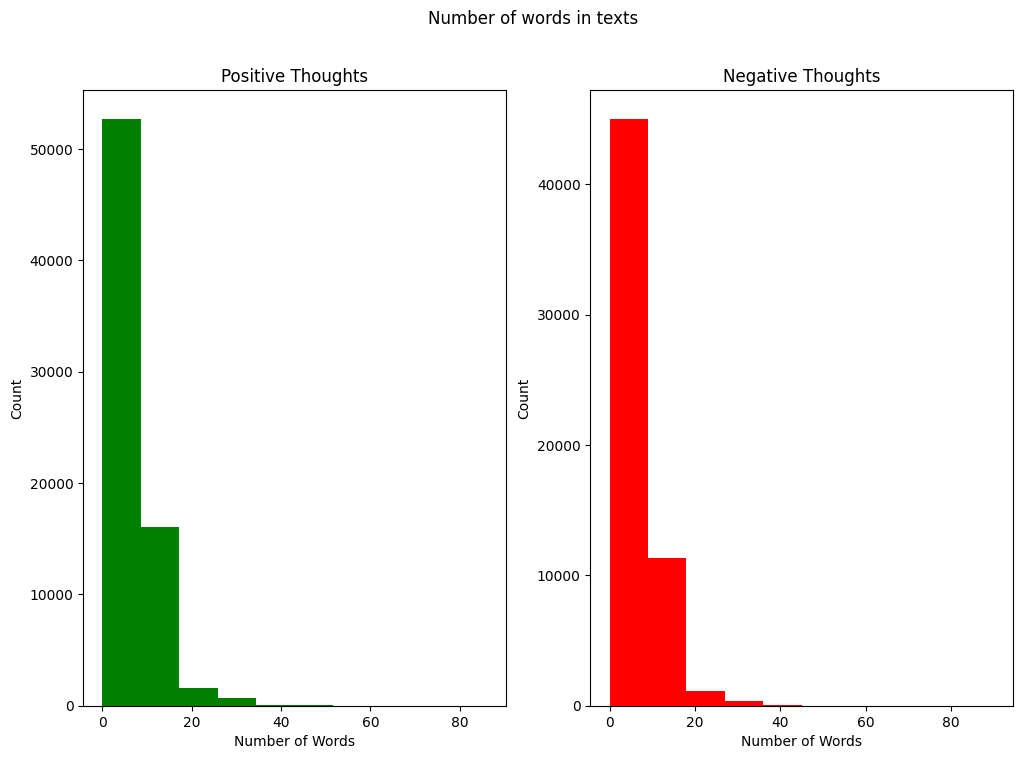

In [59]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,8))

text_len=positive_data.str.split().map(lambda x: len(x))
ax1.hist(text_len,color='green')
ax1.set_title('Positive Thoughts')
ax1.set_xlabel('Number of Words')
ax1.set_ylabel('Count')
text_len=negative_data.str.split().map(lambda x: len(x))
ax2.hist(text_len,color='red')
ax2.set_title('Negative Thoughts')
ax2.set_xlabel('Number of Words')
ax2.set_ylabel('Count')
fig.suptitle('Number of words in texts')
plt.show()

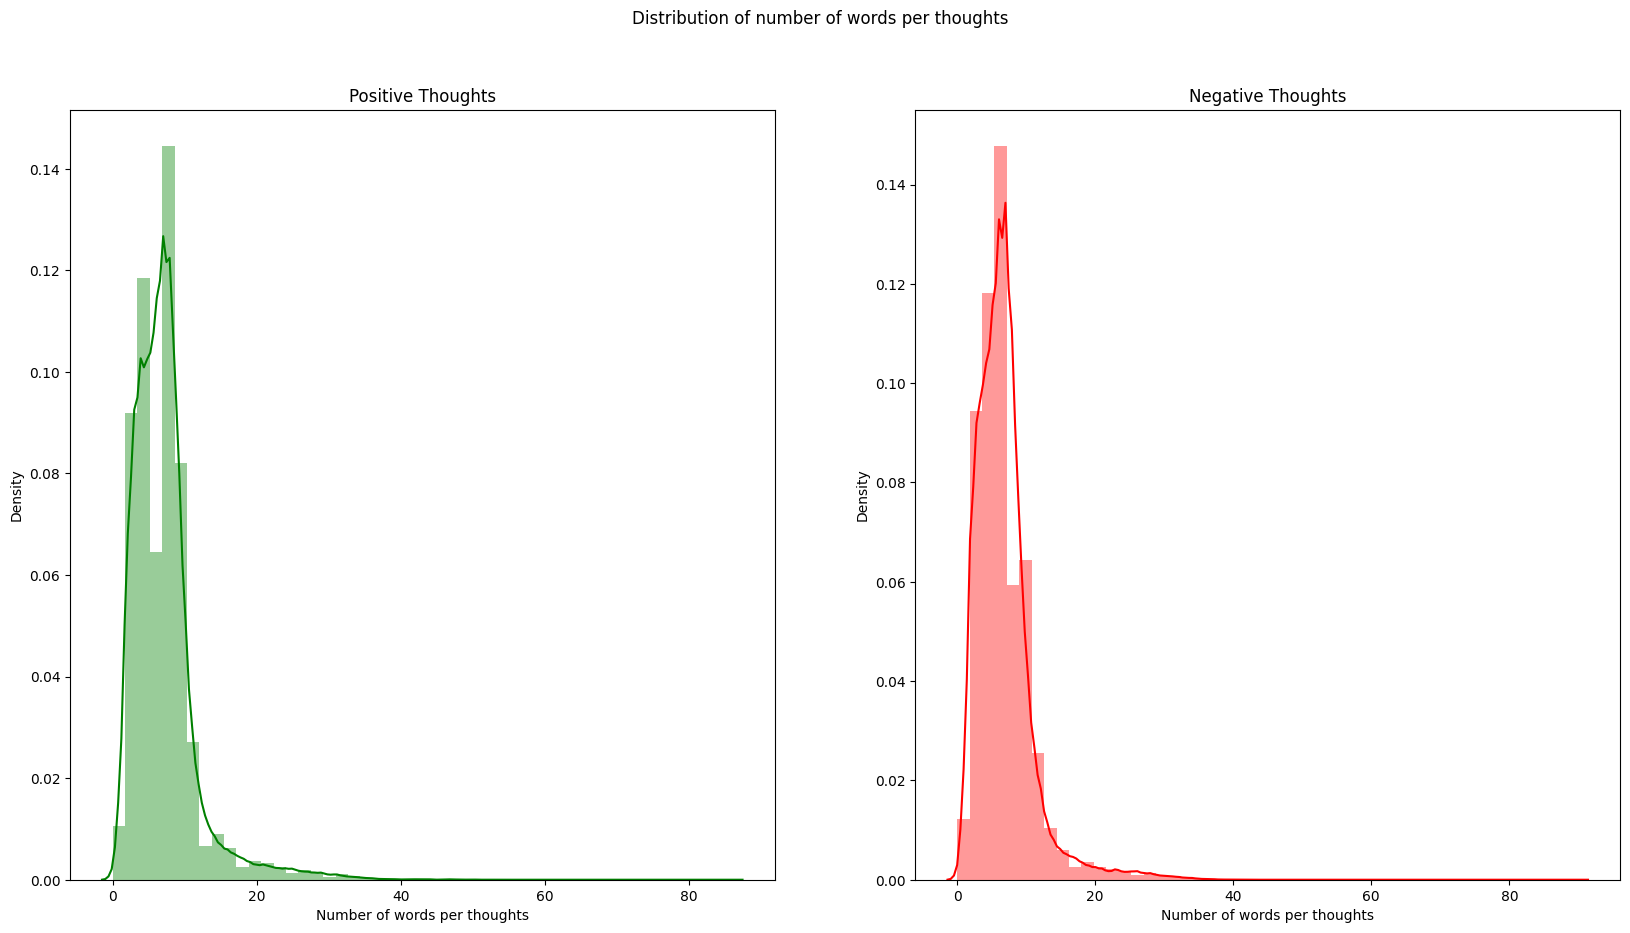

In [60]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(20,10))
word = positive_data.str.split().apply(lambda x : len(x) )
sns.distplot(word, ax=ax1,color='green')
ax1.set_title('Positive Thoughts')
ax1.set_xlabel('Number of words per thoughts')
ax1.set_ylabel('Density')
word = negative_data.str.split().apply(lambda x :len(x) )
sns.distplot(word,ax=ax2,color='red')
ax2.set_title('Negative Thoughts')
ax2.set_xlabel('Number of words per thoughts')
ax2.set_ylabel('Density')
fig.suptitle('Distribution of number of words per thoughts')
plt.show()

In [61]:
def get_corpus(text):
    words = []
    for i in text:
        for j in i.split():
            words.append(j.strip())
    return words
corpus = get_corpus(data.Thought_clean)
corpus[:10]

['everyone',
 'probably',
 'mad',
 'me',
 'you',
 'brave',
 'you',
 'believe',
 'me',
 'open']

In [62]:
from collections import Counter
counter = Counter(corpus)
most_common = counter.most_common(10)
most_common = pd.DataFrame(most_common,columns = ['corpus','countv'])
print(most_common)

   corpus  countv
0      me   45895
1    they   10486
2     you   10378
3     not   10237
4     can    6526
5    like    5100
6    help    4137
7    life    4075
8    make    3504
9  others    3480


In [63]:
most_common = most_common.sort_values('countv')

In [64]:
plt.rcParams["font.size"] = 12

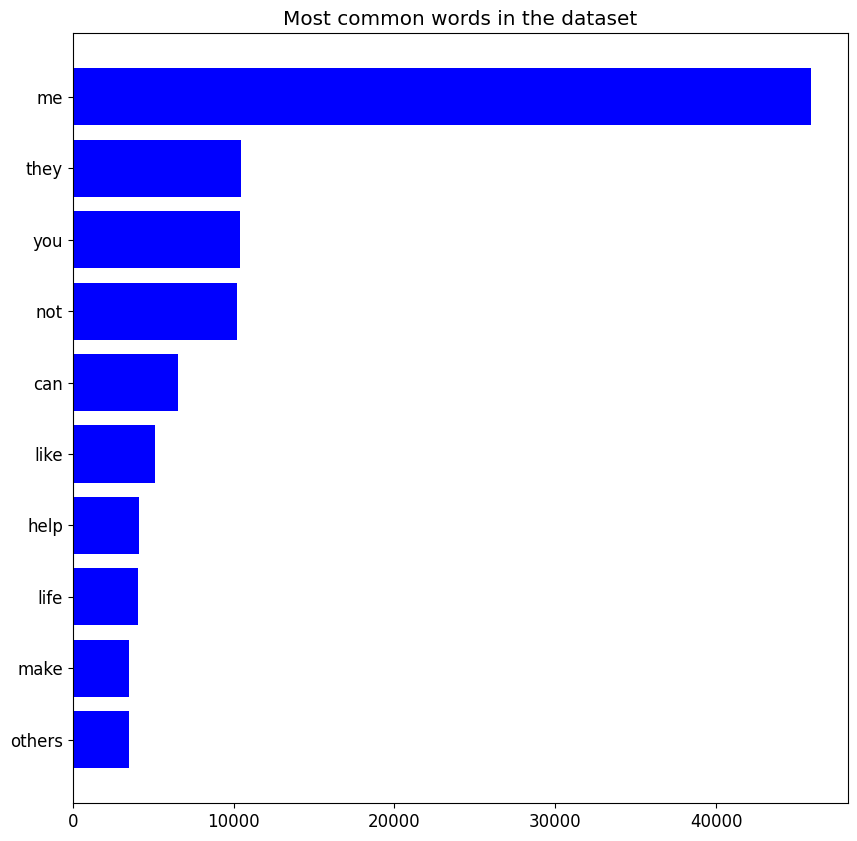

In [65]:
plt.figure(figsize =(10,10))
plt.yticks(range(len(most_common)), list(most_common.corpus))
plt.barh(range(len(most_common)), list(most_common.countv),align='center',color = 'blue')
plt.title('Most common words in the dataset')
plt.show()

In [66]:
def get_ngrams(Thought_clean, n, g):
    vec = CountVectorizer(ngram_range=(g, g)).fit(Thought_clean)
    bag_of_words = vec.transform(Thought_clean) #sparse matrix of count_vectorizer
    sum_words = bag_of_words.sum(axis=0) #total number of words
    sum_words = np.array(sum_words)[0].tolist() #convert to list
    words_freq = [(word, sum_words[idx]) for word, idx in vec.vocabulary_.items()] #get word freqency for word location in count vec
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True) #key is used to perform sorting using word_freqency
    return words_freq[:n]

In [67]:
fig = make_subplots(rows=1, cols=2, shared_yaxes=True, horizontal_spacing=0.10, subplot_titles=('Positive Thoughts','Negative Thoughts'))
fig.update_layout(title="Unigram analysis for positive and negative thoughts")
uni_positive = get_ngrams(positive_data,20,1)
uni_positive = dict(uni_positive)
temp = pd.DataFrame(list(uni_positive.items()), columns = ["Common_words" , 'Count'])
fig = px.bar(temp, x="Count", y="Common_words", title='Commmon Words in Positive Thoughts', orientation='h',
             width=600, height=600,color='Common_words')
fig.show()
uni_negative = get_ngrams(negative_data,20,1)
uni_negative = dict(uni_negative)
temp = pd.DataFrame(list(uni_negative.items()), columns = ["Common_words" , 'Count'])
fig = px.bar(temp, x="Count", y="Common_words", title='Commmon Words in Negative Thoughts',orientation='h',
             width=600, height=600,color='Common_words')

fig.show()

In [68]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

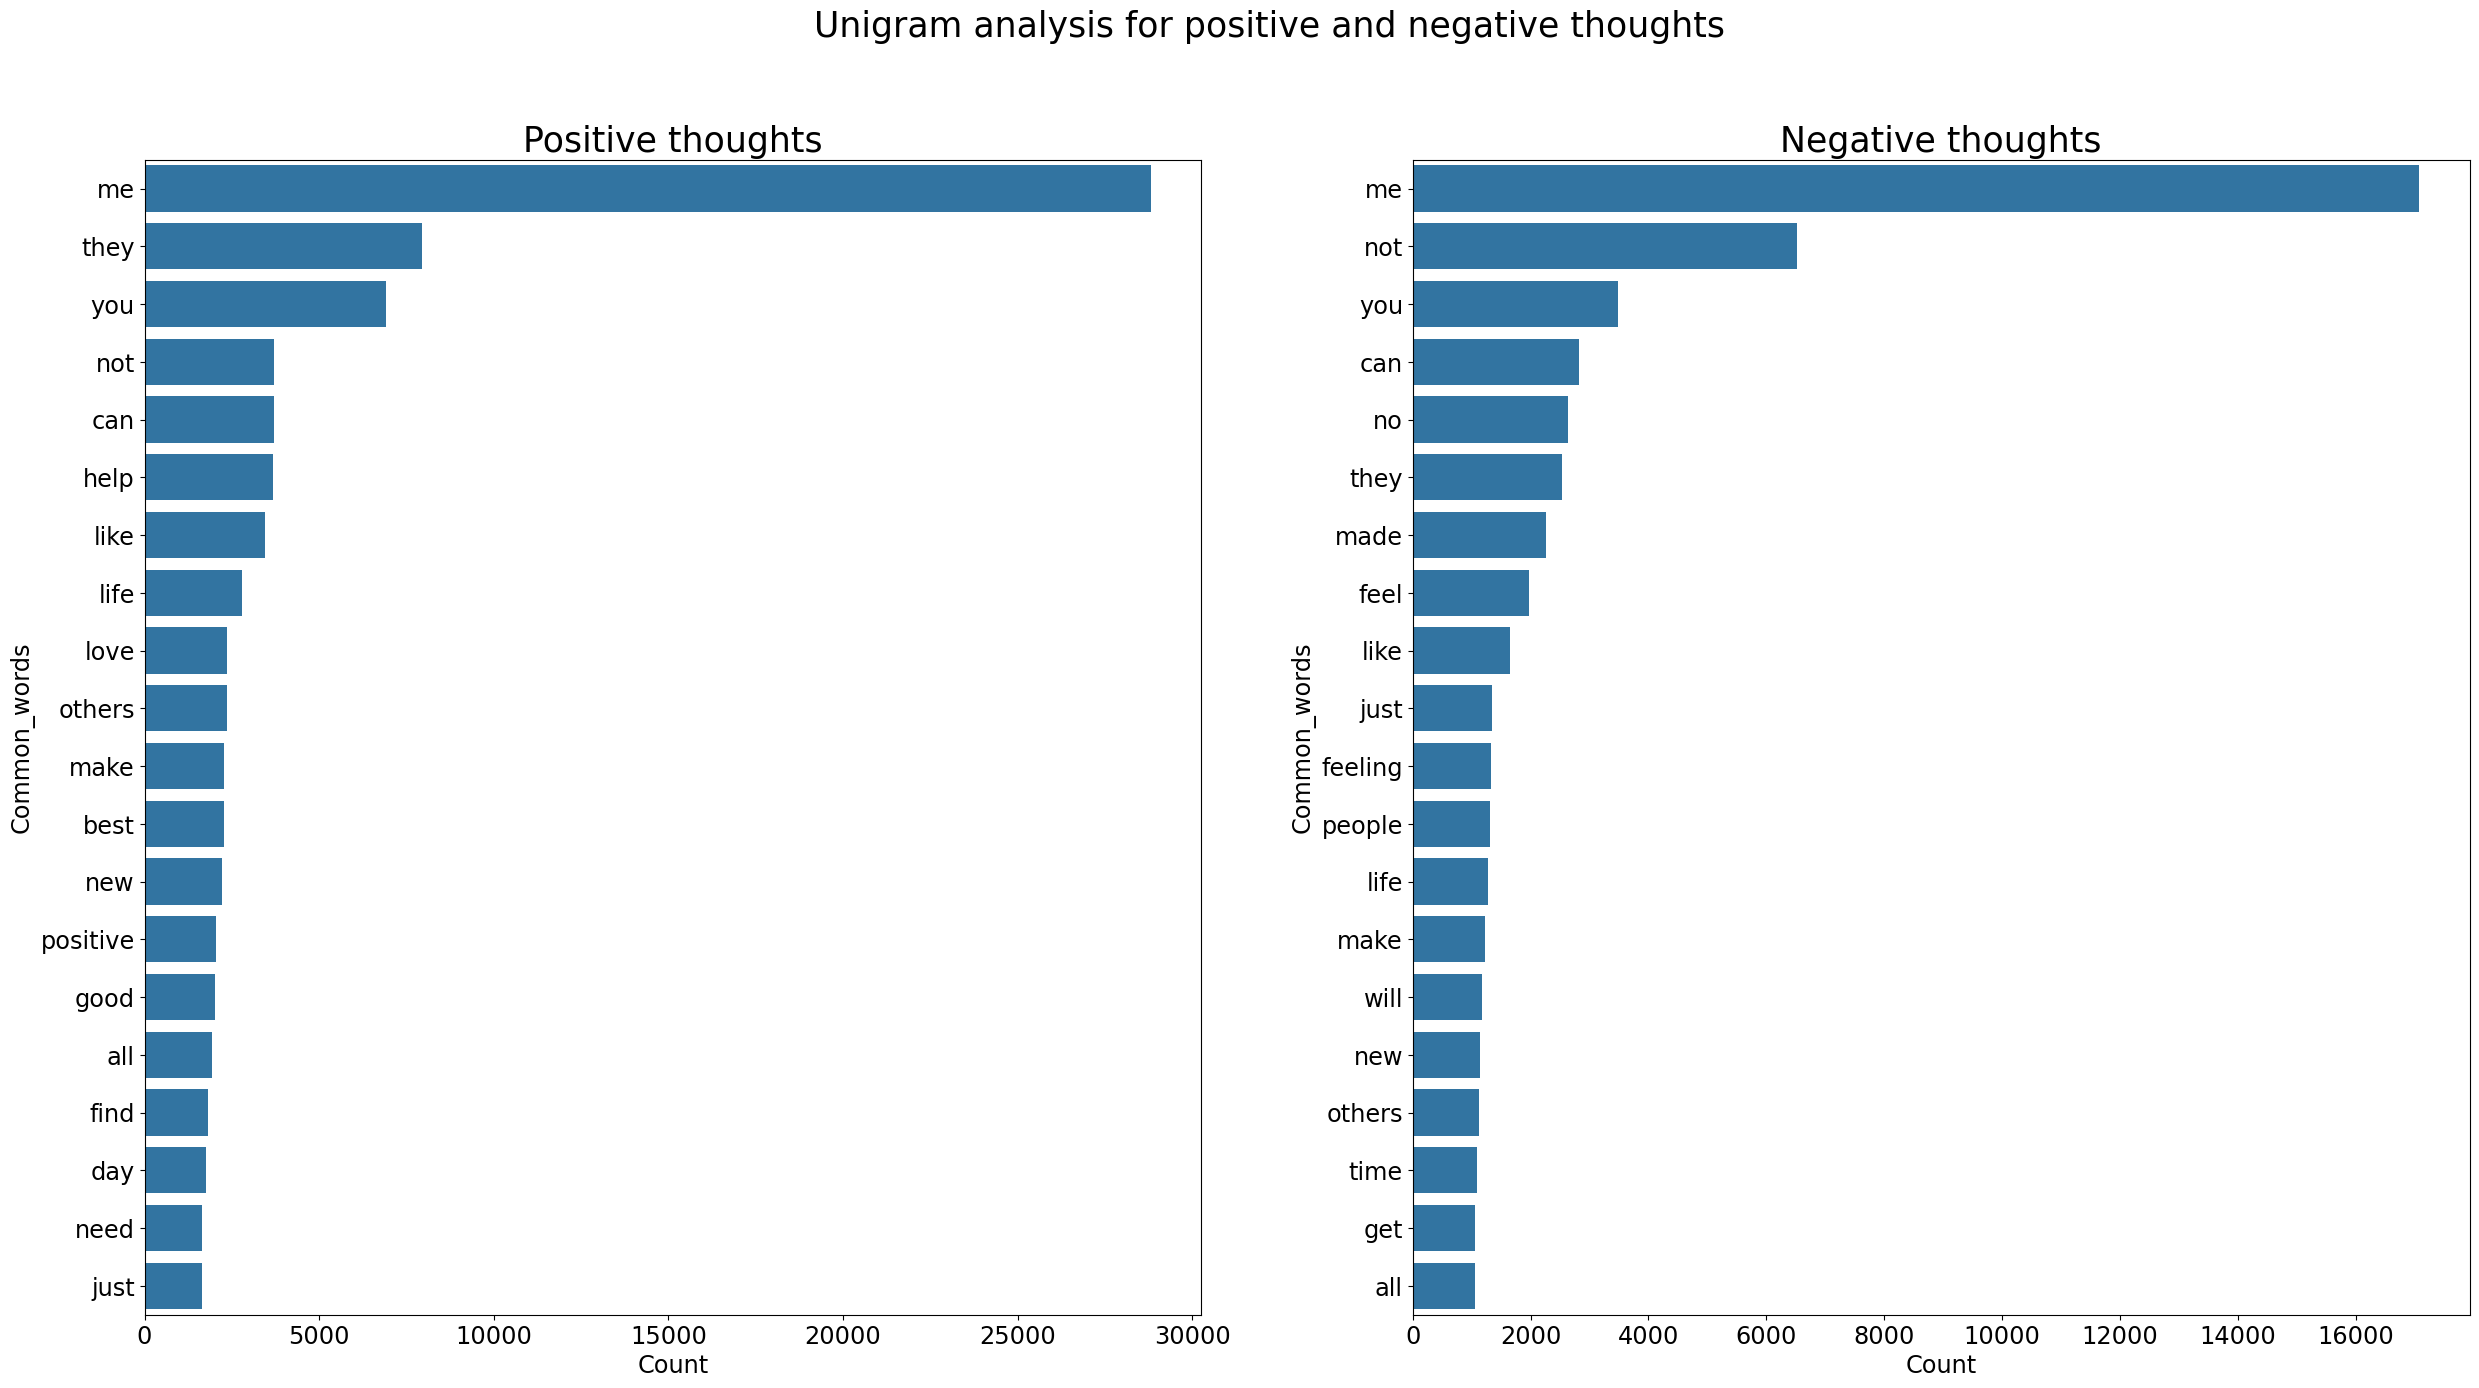

In [69]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(30,15))
uni_positive = get_ngrams(positive_data,20,1)
uni_positive = dict(uni_positive)
temp = pd.DataFrame(list(uni_positive.items()), columns = ["Common_words" , 'Count'])
sns.barplot(data = temp, x="Count", y="Common_words", orient='h',ax = ax1)
ax1.set_title('Positive thoughts', fontsize=25)
uni_negative = get_ngrams(negative_data,20,1)
uni_negative = dict(uni_negative)
temp = pd.DataFrame(list(uni_negative.items()), columns = ["Common_words" , 'Count'])
sns.barplot(data = temp, x="Count", y="Common_words", orient='h',ax = ax2)
ax2.set_title('Negative thoughts', fontsize=25)
fig.suptitle('Unigram analysis for positive and negative thoughts', fontsize=25)
plt.show()

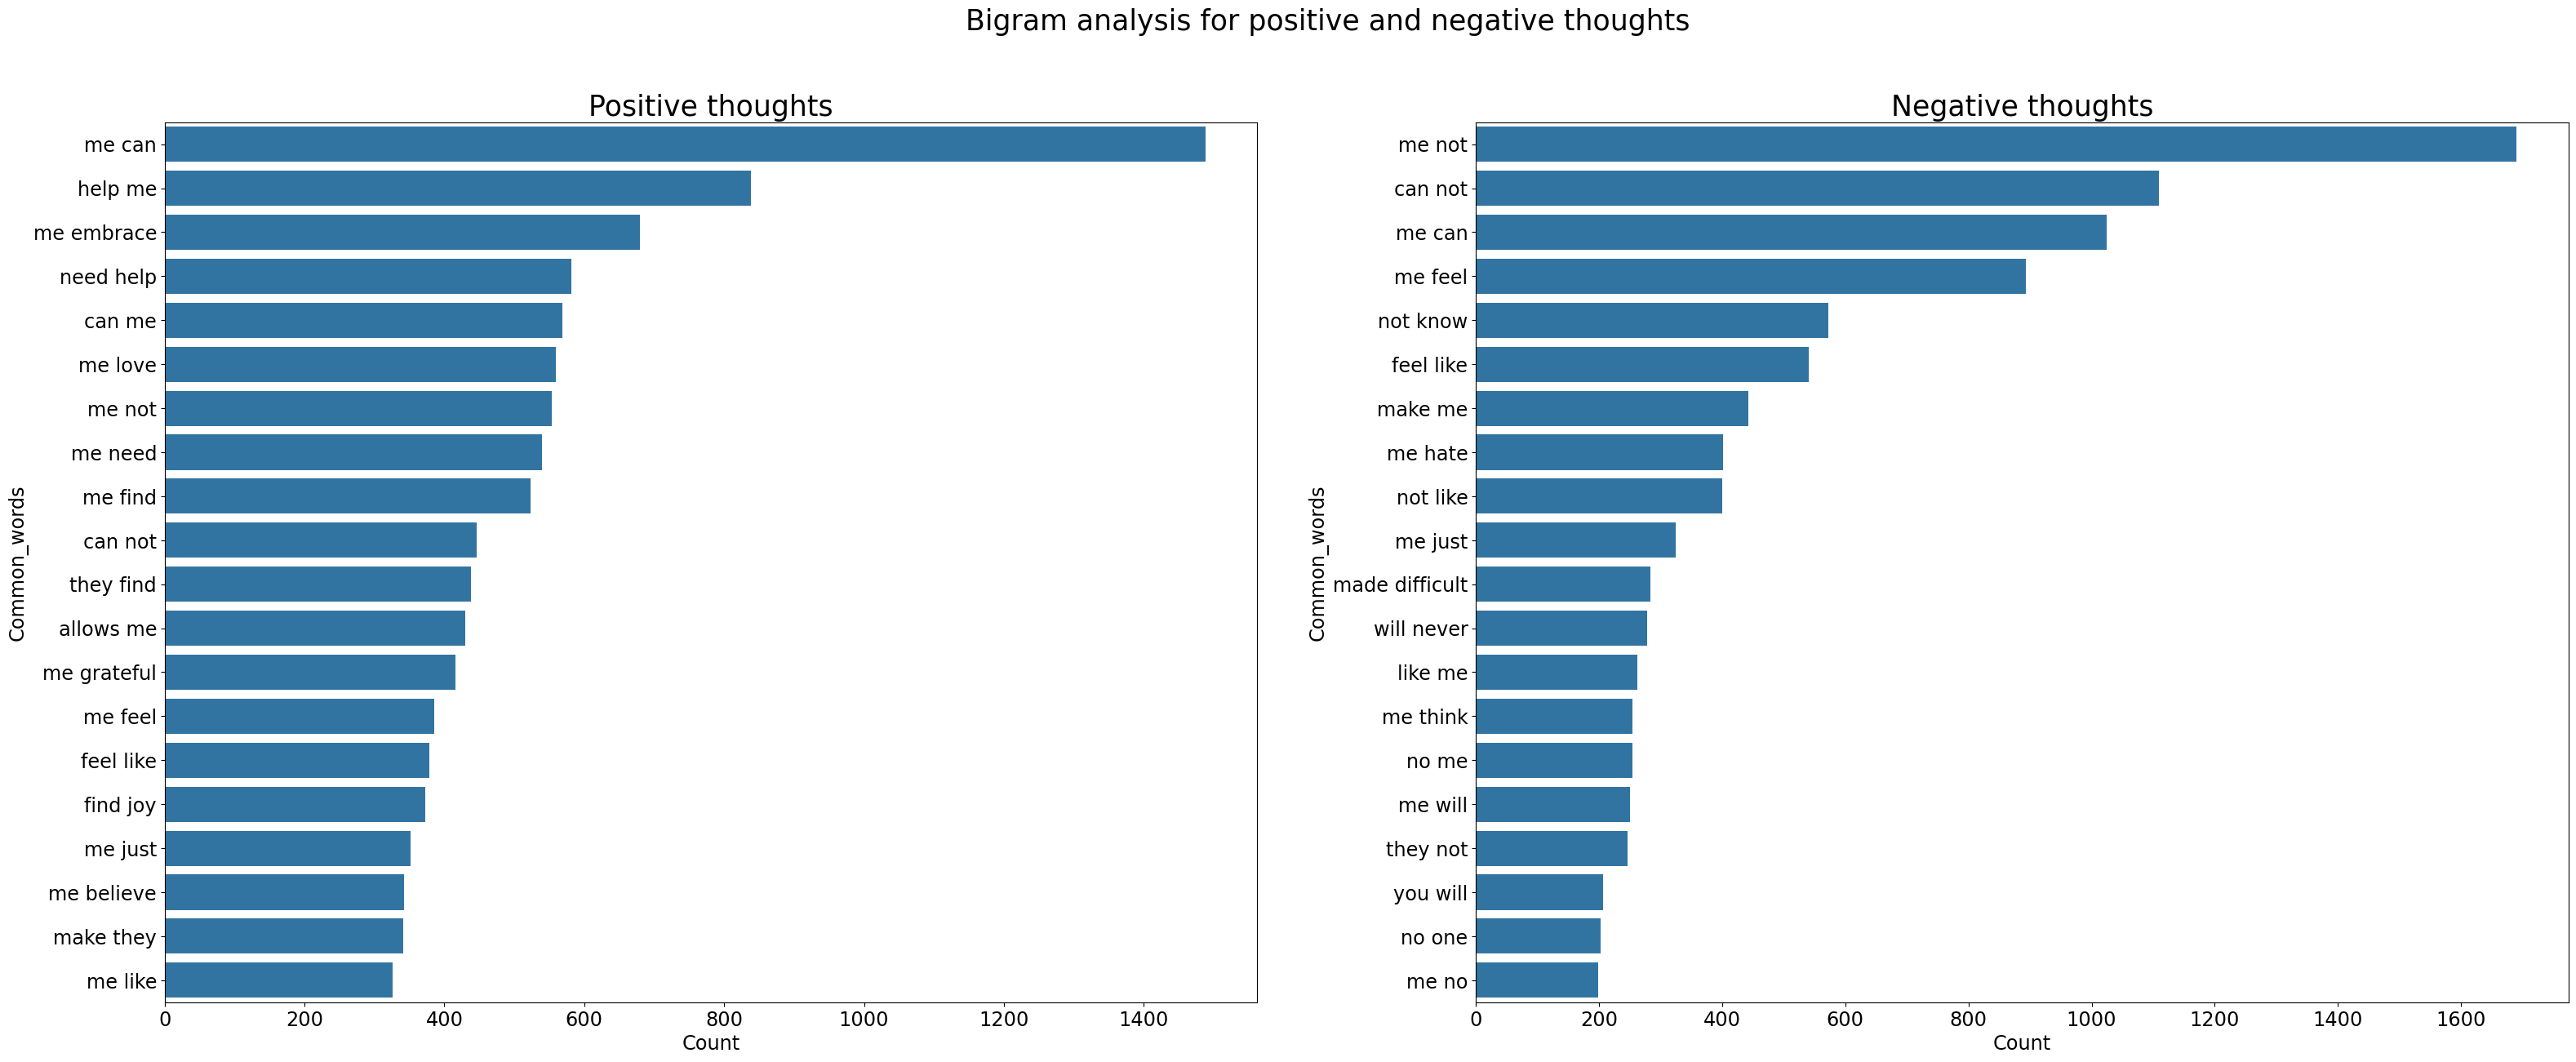

In [70]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(38,14))
bi_positive = get_ngrams(positive_data,20,2)
bi_positive = dict(bi_positive)
temp = pd.DataFrame(list(bi_positive.items()), columns = ["Common_words" , 'Count'])
sns.barplot(data = temp, x="Count", y="Common_words", orient='h',ax = ax1)
ax1.set_title('Positive thoughts', fontsize=25)
bi_negative = get_ngrams(negative_data,20,2)
bi_negative = dict(bi_negative)
temp = pd.DataFrame(list(bi_negative.items()), columns = ["Common_words" , 'Count'])

sns.barplot(data = temp, x="Count", y="Common_words", orient='h',ax = ax2)
ax2.set_title('Negative thoughts', fontsize=25)
fig.suptitle('Bigram analysis for positive and negative thoughts', fontsize=25)
plt.show()

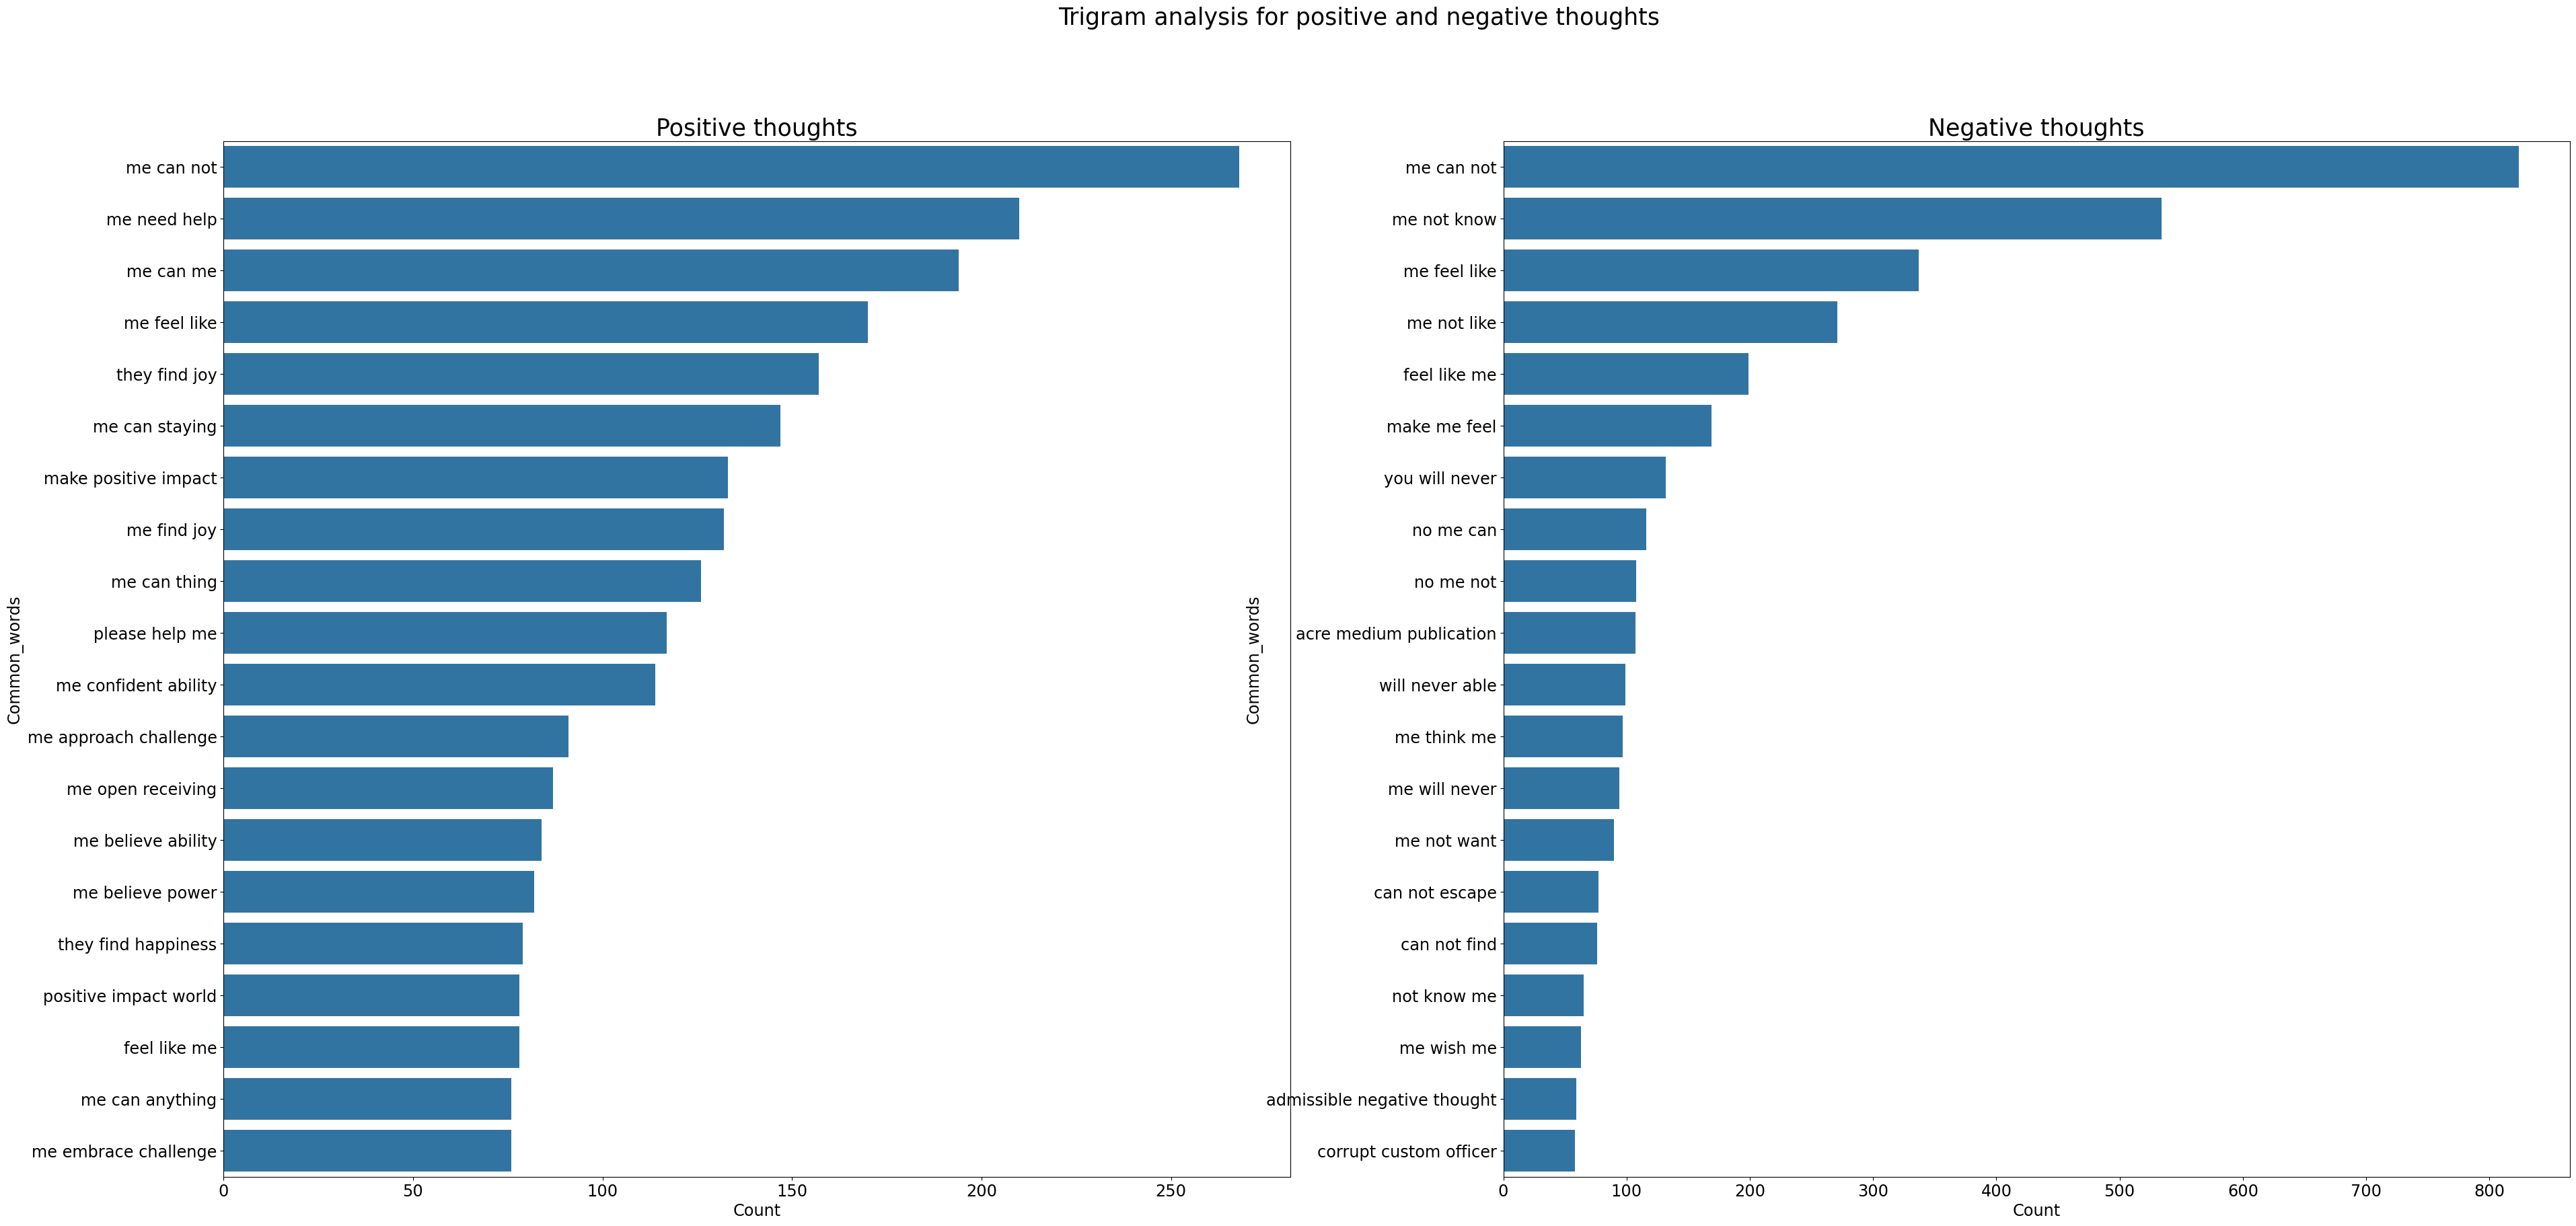

In [71]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(45,20))
tri_positive = get_ngrams(positive_data,20,3)
tri_positive = dict(tri_positive)
temp = pd.DataFrame(list(tri_positive.items()), columns = ["Common_words" , 'Count'])
sns.barplot(data = temp, x="Count", y="Common_words", orient='h',ax = ax1)
ax1.set_title('Positive thoughts', fontsize=25)
tri_negative = get_ngrams(negative_data,20,3)
tri_negative = dict(tri_negative)
temp = pd.DataFrame(list(tri_negative.items()), columns = ["Common_words" , 'Count'])
sns.barplot(data = temp, x="Count", y="Common_words", orient='h',ax = ax2)
ax2.set_title('Negative thoughts', fontsize=25)
fig.suptitle('Trigram analysis for positive and negative thoughts', fontsize=25)
plt.show()

## 5. Modelling using Machine Learning

### splitting into train and test

In [72]:
#x_train,x_test,y_train,y_test = train_test_split(data.Thought_clean,data.Label,random_state = 0 , stratify = data.Thought_clean)
train, test= train_test_split(data, test_size=0.2, random_state=42)
Xtrain, ytrain = train['Thought_clean'], train['Label']
Xtest, ytest = test['Thought_clean'], test['Label']

In [75]:
# Create dataframes for train and test
train_df = pd.DataFrame({'Thought_clean': Xtrain, 'Label': ytrain})
train_df['split'] = 'train'

test_df = pd.DataFrame({'Thought_clean': Xtest, 'Label': ytest})
test_df['split'] = 'test'

# Combine all dataframes
combined_df = pd.concat([train_df, test_df]).reset_index(drop=True)

# Save to CSV
combined_df.to_csv('ML_data_split.csv', index=False)

# Convert to dictionary for JSON
data_dict = combined_df.to_dict(orient='records')

# Save to JSON
with open('ML_data_split.json', 'w') as json_file, open('ML_data_split.json', 'w') as json_file:
    json.dump(data_dict, json_file, indent=4)

print("CSV and JSON files have been created successfully.")

CSV and JSON files have been created successfully.


### Vectorizing data

#### Term Frequency-Inverse Document Frequency model (TFIDF)
It is used to convert text documents to matrix of tfidf features.

In [122]:
tfidf_vect = TfidfVectorizer()
#transformed train text
Xtrain_tfidf = tfidf_vect.fit_transform(Xtrain)
#transformed test text
Xtest_tfidf = tfidf_vect.transform(Xtest)
print('TFIDF_train:',Xtrain_tfidf.shape)
print('TFIDF_test:',Xtest_tfidf.shape)

TFIDF_train: (103264, 24882)
TFIDF_test: (25816, 24882)


#### Count Vectorizer
It is used to convert text documents to numerical vectors or bag of words.

In [123]:
#Count vectorizer for bag of words
count_vect = CountVectorizer()
#transformed train text
Xtrain_count = count_vect.fit_transform(Xtrain)
#transformed test text
Xtest_count = count_vect.transform(Xtest)
print('BOW_cv_train:',Xtrain_count.shape)
print('BOW_cv_test:',Xtest_count.shape)

BOW_cv_train: (103264, 24882)
BOW_cv_test: (25816, 24882)


### Modeling

In [124]:
# Set the default text font size
plt.rc('font', size=12)
# Set the axes title font size
plt.rc('axes', titlesize=12)
# Set the axes labels font size
plt.rc('axes', labelsize=12)
# Set the font size for x tick labels
plt.rc('xtick', labelsize=10)
# Set the font size for y tick labels
plt.rc('ytick', labelsize=10)
# Set the legend font size
plt.rc('legend', fontsize=12)
# Set the font size of the figure title
plt.rc('figure', titlesize=12)

In [125]:
def testing_various_clf (Xtrain,Xtest,ytrain,ytest):

    models = [("LR",LogisticRegression()),
              ("DT",DecisionTreeClassifier()),
              ("MNB",MultinomialNB()),
              ("RF",RandomForestClassifier()),
              ("XGBoost",XGBClassifier()),
              ("SGD",SGDClassifier())]
    model_accuracy = []
    model_name=[]
    for name, model in models:
        print(f"{'-'*88}\n{name}\n{'-'*88}")
        ypred = model.fit(Xtrain,ytrain).predict(Xtest)
        s=accuracy_score(ytest,ypred)
        print(name,"Classifier Accuracy :", "{:.2f}%".format(100*s))
        print(classification_report(ytest,ypred,target_names=['Positive','Negative']))

        fig, ax = plt.subplots(figsize=(5, 5))
        cm = confusion_matrix(ytest, ypred)
        accuracy = np.trace(cm) / np.sum(cm).astype('float')
        misclass = 1 - accuracy
        model_accuracy.append(100*accuracy)
        model_name.append(name)
        #ConfusionMatrixDisplay.from_estimator(model, Xtest, ytest, cmap=plt.cm.Blues, display_labels=['Negative','Positive'], ax=ax, values_format="d")
        sns.heatmap(cm/np.sum(cm),annot = True,fmt ='.2%', cmap='Blues', xticklabels=['positive','negative'], yticklabels=['positive','negative'])
        plt.title('Confusion matrix of the {}'.format(name))
        plt.ylabel('True label')
        plt.xlabel('Predicted label\naccuracy={:0.2f}; misclass={:0.2f}'.format(100*accuracy, misclass))
        plt.grid(False)

    print("Accuracy of the models ", model_accuracy)
    df = pd.DataFrame(list(zip(model_name, model_accuracy)), columns=['Model', 'Accuracy'])
    plt.figure(figsize = (6,4,)) #set the figure size
    plt.autoscale()
    palette=sns.color_palette("hls", 8)
    plots=sns.barplot(data = df, x = "Model", y="Accuracy", palette=palette)
    sns.despine()
    for bar in plots.patches:
        plots.annotate(format(bar.get_height(), '.2f'),
                        (bar.get_x() + bar.get_width() / 2,
                        bar.get_height()), ha='center', va='center',
                        size=10, xytext=(0, 7),
                        textcoords='offset points')

    plt.xticks(rotation=45)
    plt.show()



###### Result Analysis on count vectorized data

Performance analysis on Count vectorized data:
----------------------------------------------------------------------------------------
LR
----------------------------------------------------------------------------------------
LR Classifier Accuracy : 92.67%
              precision    recall  f1-score   support

    Positive       0.92      0.92      0.92     11614
    Negative       0.93      0.94      0.93     14202

    accuracy                           0.93     25816
   macro avg       0.93      0.93      0.93     25816
weighted avg       0.93      0.93      0.93     25816

----------------------------------------------------------------------------------------
DT
----------------------------------------------------------------------------------------
DT Classifier Accuracy : 85.77%
              precision    recall  f1-score   support

    Positive       0.87      0.81      0.84     11614
    Negative       0.85      0.90      0.87     14202

    accuracy                        

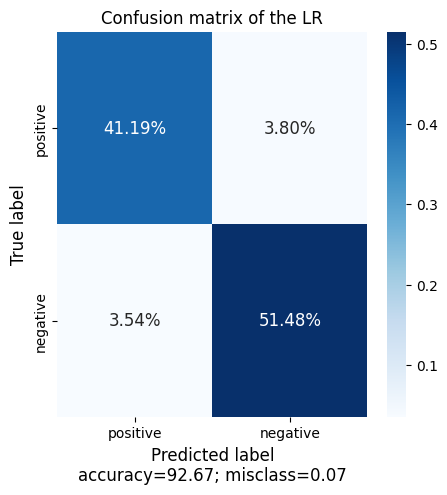

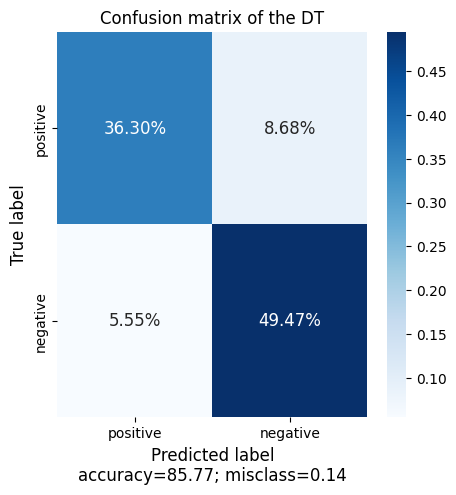

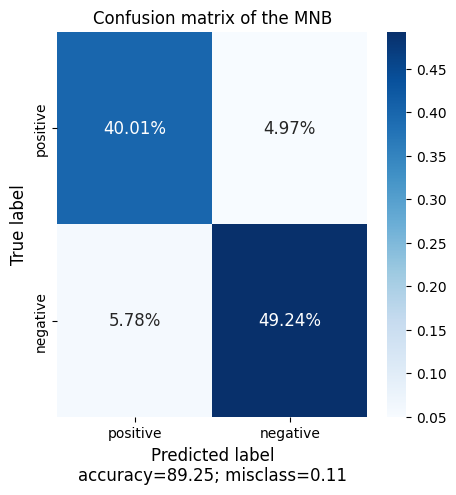

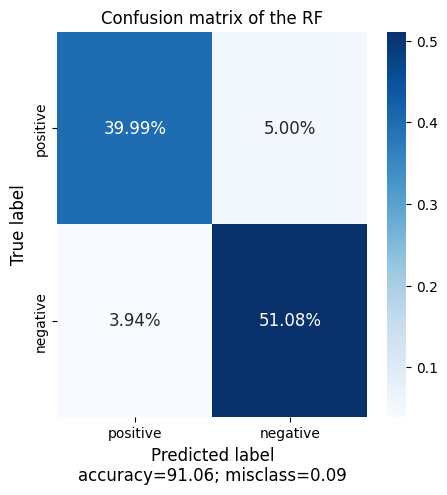

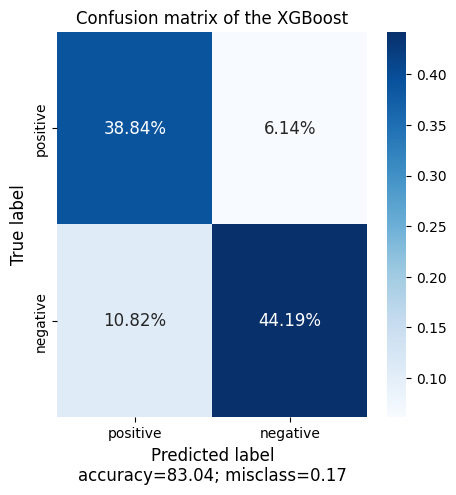

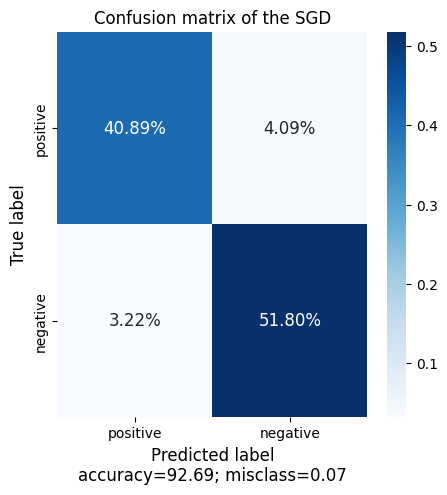

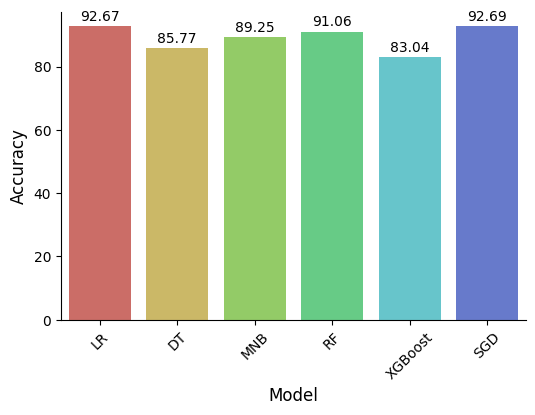

In [126]:
print("Performance analysis on Count vectorized data:")
testing_various_clf(Xtrain_count,Xtest_count,ytrain,ytest)

###### Result Analysis on tf-idf vectorized data

Performance analysis on Tf-IDF vectorized data:
----------------------------------------------------------------------------------------
LR
----------------------------------------------------------------------------------------
LR Classifier Accuracy : 92.54%
              precision    recall  f1-score   support

    Positive       0.92      0.91      0.92     11614
    Negative       0.93      0.93      0.93     14202

    accuracy                           0.93     25816
   macro avg       0.92      0.92      0.92     25816
weighted avg       0.93      0.93      0.93     25816

----------------------------------------------------------------------------------------
DT
----------------------------------------------------------------------------------------
DT Classifier Accuracy : 85.69%
              precision    recall  f1-score   support

    Positive       0.86      0.81      0.84     11614
    Negative       0.85      0.89      0.87     14202

    accuracy                       

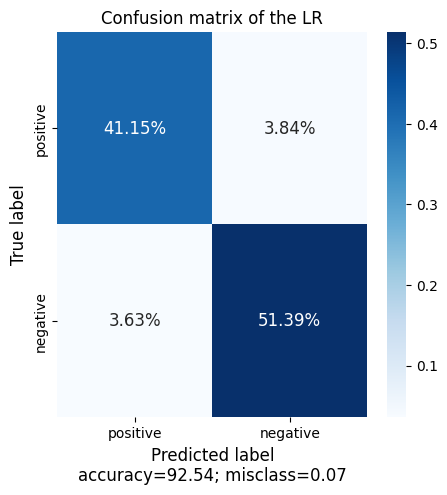

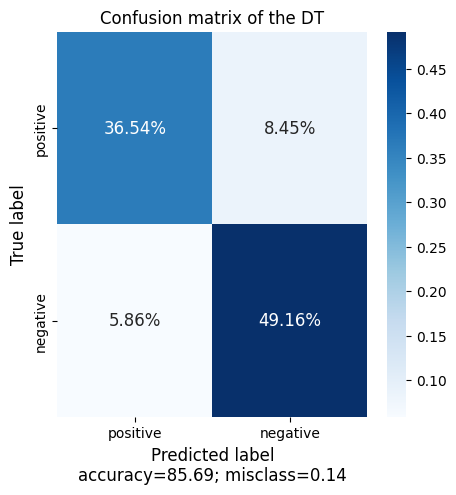

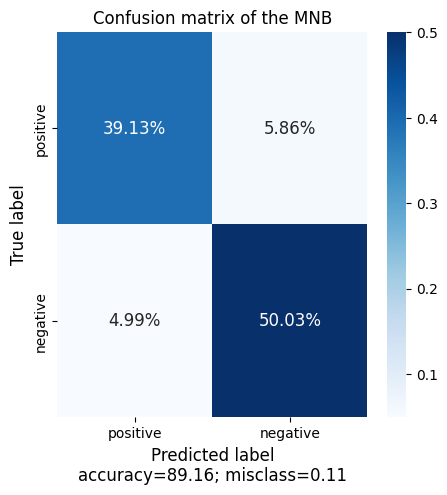

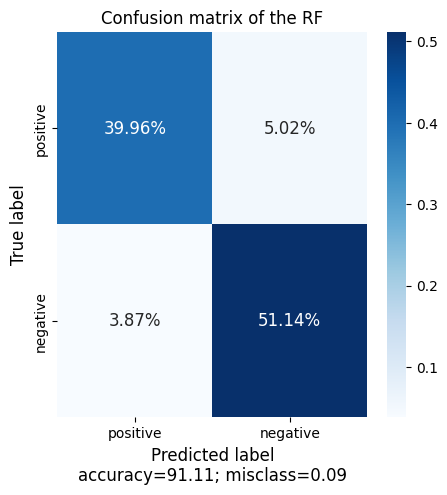

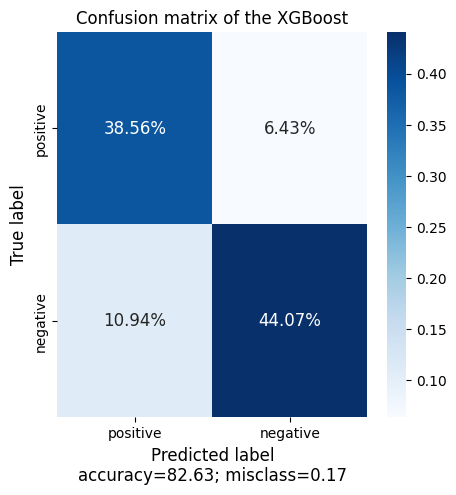

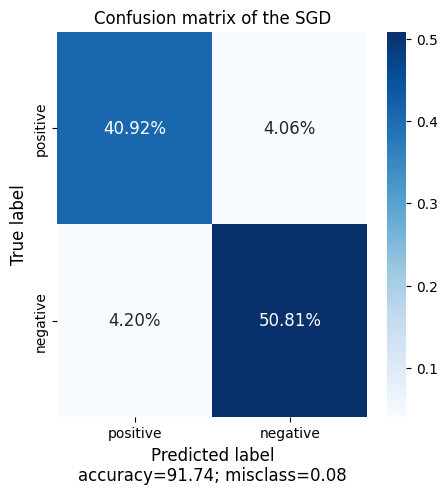

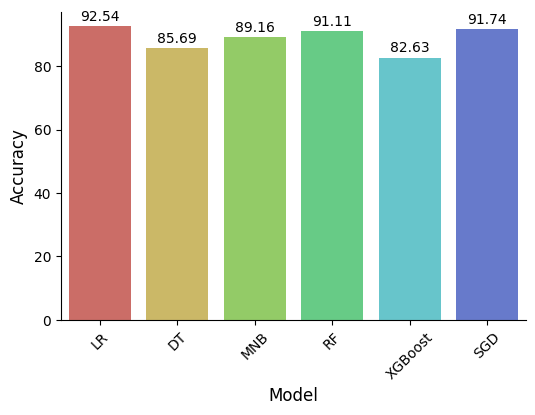

In [127]:
print("Performance analysis on Tf-IDF vectorized data:")
testing_various_clf(Xtrain_tfidf,Xtest_tfidf,ytrain,ytest)

In [128]:
print(SGDClassifier().fit(Xtrain_tfidf,ytrain).predict(tfidf_vect.transform(['A good Article'])))

[1]


In [129]:
print(LogisticRegression().fit(Xtrain_count,ytrain).predict(count_vect.transform(['I did not like this book at all, I gave this book away'])))

[0]
